# Common-mode, c(t), analysis from first iterative map maker trials

The common-mode, c(t), is determined as the mean of all the detector timestreams. It captures instrument and sky that are common to all detectors, but both because astronomical signals are scanned across the array, and because each detector has a slight physical offset, astronomical signals are mostly absent from the mean. However, because we use the mean to calculate c(t), bright sources will have a noticeable impact and after c(t) subtraction from each timestream there will be left a weak 'dark' patch around sources which will affect weak signals, e.g. molecular clouds.

To improve the c(t) estimation, we use an iterative process by which we

calculate c(t) as the mean of all the timestreams,

then subtract from each,

calculate a combined map,

determine new detector timestream estimates from this map,

and use the new estimated timestreams to calculate a new c(t).

This improves the estimate of c(t) because the new estimated detector timestreams more accurately represent what the 'true' astronomical-signal-only timestream would look like and thus the new c(t) calculated from them will include only the component of c(t) that was astronomical signal (i.e. the over-estimation). Thus subtracting this new c(t) from the original yields a better overall estimate.

This can be repeated to iteratively improve the estimate of c(t), and c(t) is expected to asymptote towards the best estimate this method can produce with each iteration.

In [1]:
# imports

import os
from pickle import UnpicklingError

import numpy as np
import paramiko
from matplotlib import pyplot as plt
import matplotlib.colors as colors

In [2]:
# config and settings

id_map = 'map_2025-01-08-T18_51_06Z'

dir_remote_base = '/home/player1/map_making_blasttng/map_maker_iterative/'
ssh_deets = ['cube', 'player1', '/Users/james/.ssh/id_ed25519'] # host, user, pass

dir_local = os.path.join(os.getcwd(), id_map)
dir_remote = os.path.join(dir_remote_base, id_map)

fnames = ['combined_map.npy', 'common_mode_roach1.dat.npy', 'align/shifts.npy']

iter_dir_prefix = 'it_'

In [3]:
# def sshConnect():
#     '''Establish an SSH connection.
#     
#     Depends on global variables:
#     ssh_deets = ['host', 'user', 'path_to_ssh_key']
#     '''
#     
#     ssh = paramiko.SSHClient()
#     ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
#     ssh.connect(ssh_deets[0], username=ssh_deets[1], port=22,
#                 pkey=paramiko.Ed25519Key.from_private_key_file(ssh_deets[2]))
#     
#     return ssh


# def downloadFiles():
#     '''Download map files.
#     
#     Depends on global variables:
#     dir_remote
#     dir_local
#     iter_dir_prefix = 'prefix'
#     fnames = ['filename_1', 'filename_2']
#     '''
#     
#     try:   
#         # establish ssh connection
#         ssh = sshConnect()
# 
#         # check map dir exists remotely
#         stdin, stdout, stderr = ssh.exec_command(f'[[ -d "{dir_remote}" ]] && echo "exists" || echo "not exists"')
#         if not stdout.read().decode().strip() == "exists": # remote dir doesn't exist
#             raise FileNotFoundError("Error: Remote directory doesn't exist.")
# 
#         # create local base dir
#         os.makedirs(dir_local)
# 
#         # get iteration dirs
#         stdin, stdout, stderr = ssh.exec_command(f'ls -d {dir_remote}/{iter_dir_prefix}*')
#         dirs_it = stdout.read().decode().strip().splitlines()
#         print(f"Downloading files in {len(dirs_it)} iterations folders...", end="")
#         for dir_it_remote in dirs_it:
#             dir_it_local = os.path.join(dir_local, os.path.basename(dir_it_remote))
#             print(f" {dir_it_local[-1]}", end="")
# 
#             # create local iteration dir
#             os.makedirs(dir_it_local)
# 
#             # download requested files in each iteration dir
#             for fname in fnames:
#                 local_path = os.path.join(dir_it_local, os.path.basename(fname)) # flatten file struct.
#                 remote_path = os.path.join(dir_it_remote, fname)
#                 sftp = ssh.open_sftp()
#                 sftp.get(remote_path, local_path)
#                 sftp.close()
# 
#         print(" Done.")
#         ssh.close() 
# 
#     except paramiko.AuthenticationException:
#         print("Error: Authentication failed. Try authenticating via the terminal first.")
#         return False
# 
#     except FileNotFoundError as e:
#         print({e})
#         return False
# 
#     except Exception as e:
#         print(f"Error: {e}")
#         return False


def loadFiles():
    '''Load map files into memory. Download first if necessary.
    
    Depends on global variables:
    dir_local
    '''
    
    if not os.path.exists(dir_local):
        print(f"Error: Map file folder {id_map} not found")
        # downloadFiles(dir_local)
            
    # load files into memory
    file_contents = {}
    for root, dirs, files in os.walk(dir_local):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                file_contents[file_path] = np.load(file_path, allow_pickle=True)
            except Exception as e:
                print(e)
            # with open(file_path, 'r') as f:
            #     file_contents[file_path] = f.read()
    
    return file_contents
        
# loadFiles() 

In [4]:
def fileKeys():
    for key in loadFiles().keys():
        print(key)
fileKeys()

Failed to interpret file 'C:\\Users\\Jonah\\PycharmProjects\\map_making_blasttng\\map_2025-01-08-T18_51_06Z\\map_making.log' as a pickle
C:\Users\Jonah\PycharmProjects\map_making_blasttng\map_2025-01-08-T18_51_06Z\it_0\combined_map.npy
C:\Users\Jonah\PycharmProjects\map_making_blasttng\map_2025-01-08-T18_51_06Z\it_0\common_mode_roach1.dat.npy
C:\Users\Jonah\PycharmProjects\map_making_blasttng\map_2025-01-08-T18_51_06Z\it_0\align\shifts_source.npy
C:\Users\Jonah\PycharmProjects\map_making_blasttng\map_2025-01-08-T18_51_06Z\it_0\align\shifts_xy_layout.npy
C:\Users\Jonah\PycharmProjects\map_making_blasttng\map_2025-01-08-T18_51_06Z\it_0\single_maps\map_kid_0000.npy
C:\Users\Jonah\PycharmProjects\map_making_blasttng\map_2025-01-08-T18_51_06Z\it_0\single_maps\map_kid_0001.npy
C:\Users\Jonah\PycharmProjects\map_making_blasttng\map_2025-01-08-T18_51_06Z\it_0\single_maps\map_kid_0002.npy
C:\Users\Jonah\PycharmProjects\map_making_blasttng\map_2025-01-08-T18_51_06Z\it_0\single_maps\map_kid_0003.

In [5]:
def pathFromLocal(*args):
    cur = dir_local
    for path_dir in args:
        cur = os.path.join(cur, path_dir)
    return cur

Failed to interpret file 'C:\\Users\\Jonah\\PycharmProjects\\map_making_blasttng\\map_2025-01-08-T18_51_06Z\\map_making.log' as a pickle
dir_local='C:\\Users\\Jonah\\PycharmProjects\\map_making_blasttng\\map_2025-01-08-T18_51_06Z'


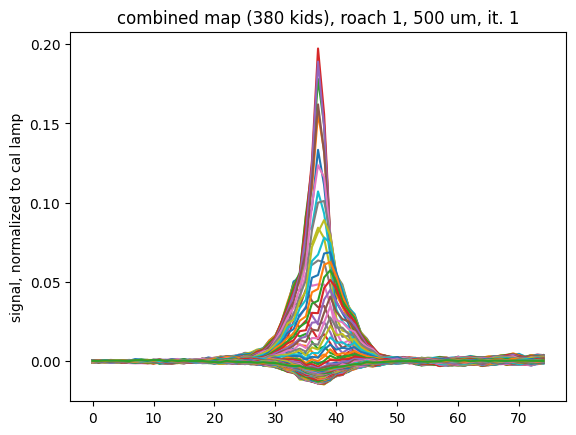

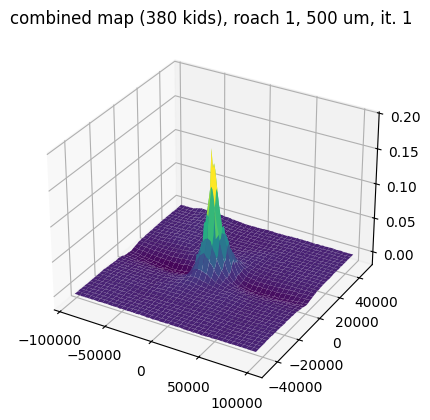

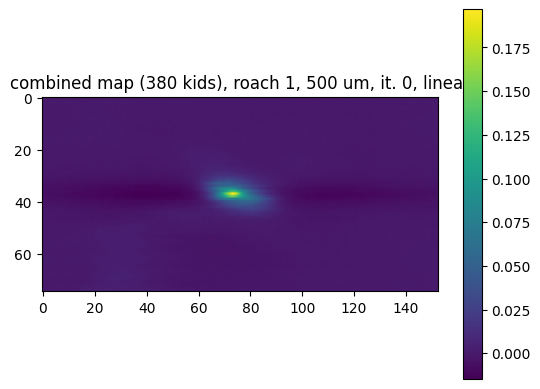

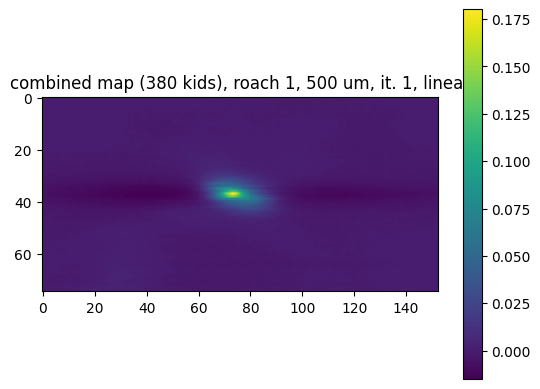

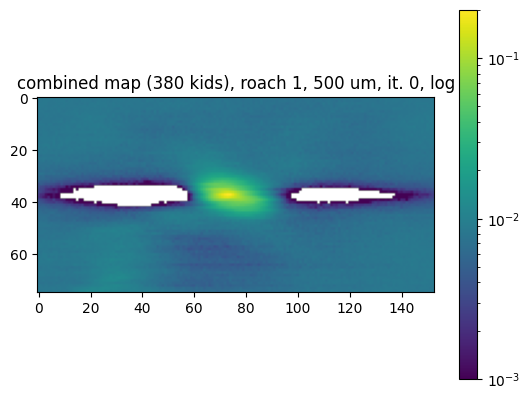

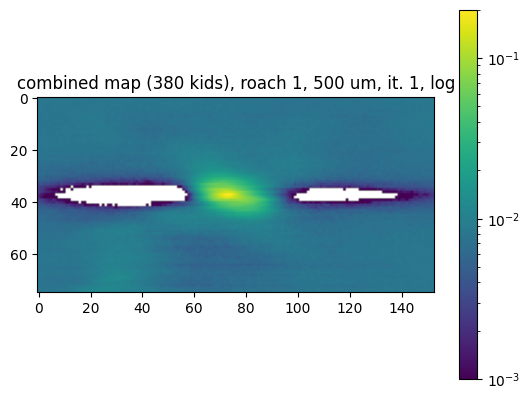

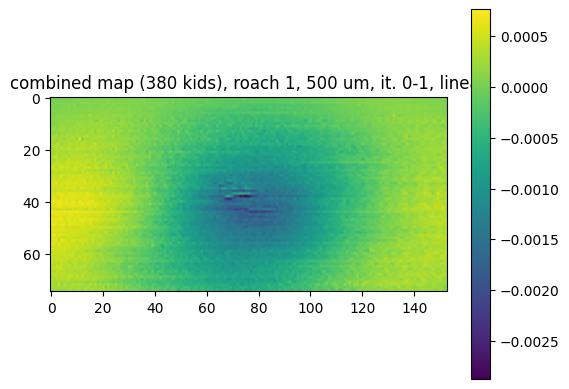

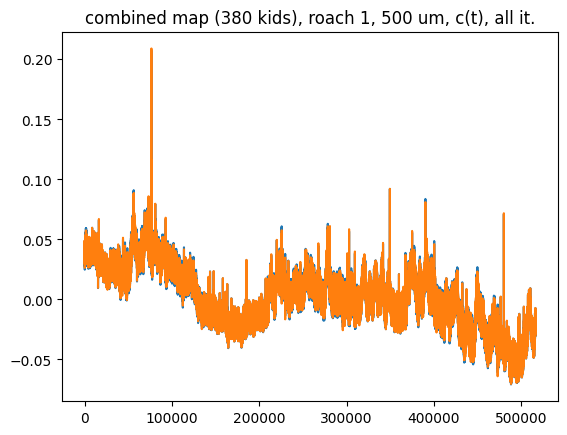

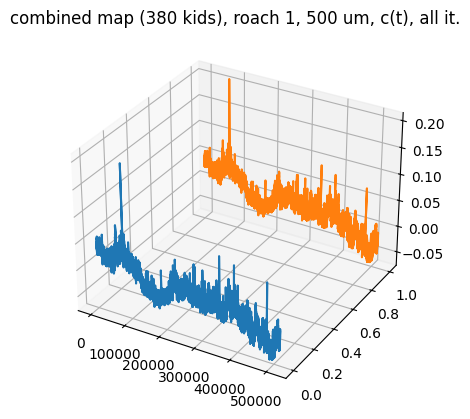

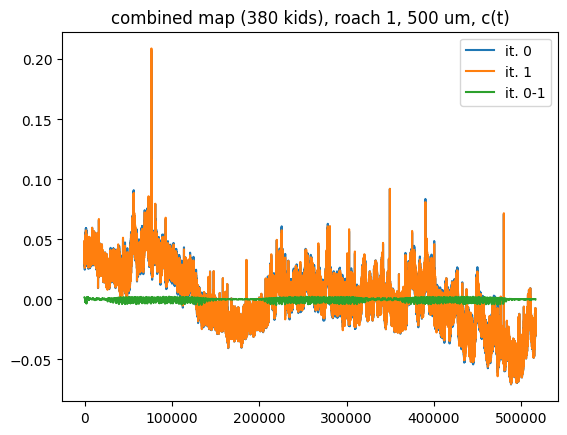

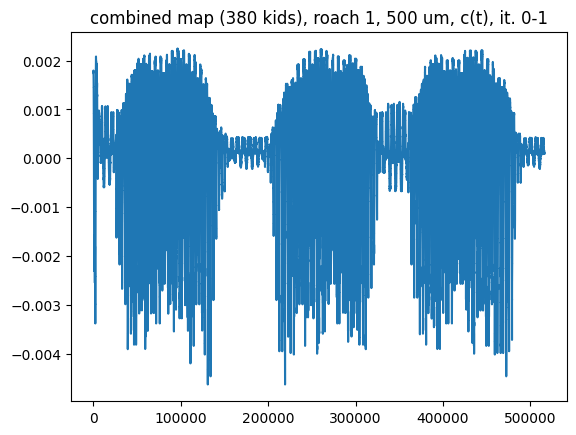

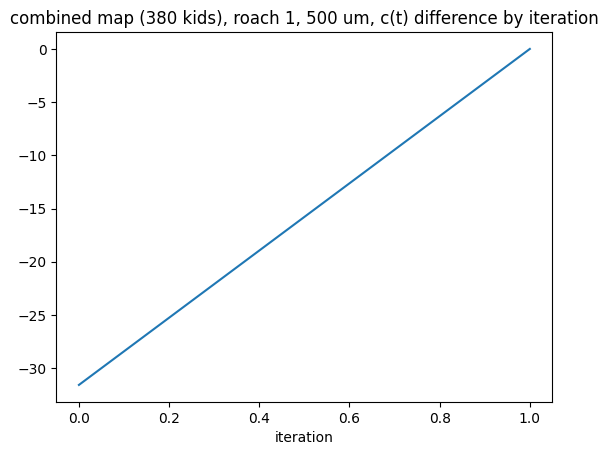

In [8]:
def doit():
    file_contents = loadFiles() # load here so unloaded again quickly
    
    # print(file_contents.keys())
    
    # for key in file_contents.keys():
        # print(key)
        
    print(f'{dir_local=}')    
    
    num_iters = 2
    
    iter_0_path = pathFromLocal('it_0', 'combined_map.npy')
    iter_1_path = pathFromLocal('it_1', 'combined_map.npy')
    
    # interesting 1D plot where each row is a line
    img = file_contents[iter_1_path]
    # img: 3d numpy array (3 x 75 x 163)
    #    img[0] (-100,000 - 100,000) <- x-position?
    #    img[1] (-50,000, 50,000) <- y-position?
    #    img[2] (-0.01 - 0.197) <- signal strength
    plt.plot(img[2])
    plt.title("combined map (380 kids), roach 1, 500 um, it. 1")
    plt.ylabel("signal, normalized to cal lamp")
    plt.show()
    
    # cool 3D view of a map
    img = file_contents[iter_1_path]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(img[0], img[1], img[2], cmap='viridis')
    plt.title("combined map (380 kids), roach 1, 500 um, it. 1")
    plt.show()

    # standard linear map of iter 0
    img = file_contents[iter_0_path]
    plt.imshow(img[2])
    plt.colorbar()
    plt.title("combined map (380 kids), roach 1, 500 um, it. 0, linear")
    plt.show()
    
    # standard linear map of iter 1
    img = file_contents[iter_1_path]
    plt.imshow(np.log1p(img[2]))
    plt.colorbar()
    plt.title("combined map (380 kids), roach 1, 500 um, it. 1, linear")
    plt.show()
    
    # log map of iter 0
    img = file_contents[iter_0_path]
    norm = colors.LogNorm(vmin=0.001, vmax=0.2)
    plt.imshow(img[2]+0.008, norm=norm, cmap='viridis')
    plt.colorbar()
    plt.title("combined map (380 kids), roach 1, 500 um, it. 0, log")
    plt.show()
    
    # log map of iter 1
    img = file_contents[iter_1_path]
    norm = colors.LogNorm(vmin=0.001, vmax=0.2)
    plt.imshow(img[2]+0.008, norm=norm, cmap='viridis')
    plt.colorbar()
    plt.title("combined map (380 kids), roach 1, 500 um, it. 1, log")
    plt.show()
    
    # difference between iter 0 and 1 (0-1)
    img1 = file_contents[iter_0_path]
    img2 = file_contents[iter_1_path]
    plt.imshow(img1[2] - img2[2])
    plt.colorbar()
    plt.title("combined map (380 kids), roach 1, 500 um, it. 0-1, linear")
    plt.show()
    
    
    # all commonmodes
    for it in range(num_iters):
        img = file_contents[pathFromLocal(f'it_{it}', 'common_mode_roach1.dat.npy')]
        plt.plot(img)
    plt.title("combined map (380 kids), roach 1, 500 um, c(t), all it.")
    plt.show()
        
    # all commonmodes 3D        
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for it in range(num_iters):
        img = file_contents[pathFromLocal(f'it_{it}', 'common_mode_roach1.dat.npy')]
        x = np.arange(len(img))  # X-axis: indices of array
        z = img  # Y-axis: array values
        y = np.full_like(x, it)  # Z-axis: array number
        ax.plot(x, y, z, label=f'Array {it+1}')
    plt.title("combined map (380 kids), roach 1, 500 um, c(t), all it.")
    plt.show()
    
    # commonmode 0
    img = file_contents[pathFromLocal('it_0', 'common_mode_roach1.dat.npy')]
    plt.plot(img, label="it. 0")
    
    # commonmode 1
    img = file_contents[pathFromLocal('it_1', 'common_mode_roach1.dat.npy')]
    plt.plot(img, label="it. 1")
    
    # commonmode difference (0-1)
    img1 = file_contents[pathFromLocal('it_1', 'common_mode_roach1.dat.npy')]
    img2 = file_contents[pathFromLocal('it_0', 'common_mode_roach1.dat.npy')]
    plt.plot(img1-img2, label="it. 0-1")
    
    plt.title("combined map (380 kids), roach 1, 500 um, c(t)")
    plt.legend()
    plt.show()
    
    plt.plot(img1-img2)
    plt.title("combined map (380 kids), roach 1, 500 um, c(t), it. 0-1")
    plt.show()
    
    # commonmode difference by generation
    img0 = file_contents[pathFromLocal('it_1', 'common_mode_roach1.dat.npy')]
    img_diffs = []
    for it in range(num_iters):
        img_diff = img0 - file_contents[pathFromLocal(f'it_{it}', 'common_mode_roach1.dat.npy')]
        img_diffs.append(np.sum(img_diff))
    plt.title("combined map (380 kids), roach 1, 500 um, c(t) difference by iteration")
    plt.xlabel("iteration")
    plt.plot(img_diffs)
    
    
doit()